Le but de cette section est de réaliser une analyse en composantes principales pour essayer de déterminer les variables principales du modèle, tout en les décorrélant un maximum.

On récupère dans un premier temps nos données en retirant toutes les cartes dont le prix minimum est inférieur à 5 centimes.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

original_data = pd.read_csv("original_data.csv")
original_data.to_csv("working_data.csv", index = False)

data = pd.read_csv("working_data.csv")
data = data[(data["Rareté"] != "Online Code Card") & (data["Rareté"] != "Oversized") & (data["Rareté"] != "Fixed")]
data = data.dropna(subset=["Min price"])

data["Min price"] = (data['Min price'].str[:-5] + data['Min price'].str[-4:-2]).astype(int)/100
data = data[(data["Min price"] >= 0.5)]

On doit garder seulement les colonnes qui possèdent des valeurs numériques pour l'ACP, et retirer le symbole "euro" dans les dernières colonnes. On garde le nom des cartes dans une variable qu'on utilisera plus tard au moment de réaliser l'ACP.


In [3]:
data["Price trend num"] = data["Price trend"].str[:-5]+"."+data["Price trend"].str[-4:-2]
data["Price 7 days num"] = data["Price 7 days"].str[:-5]+"."+data["Price 7 days"].str[-4:-2]
data["Price 30 days num"] = data["Price 30 days"].str[:-5]+"."+data["Price 30 days"].str[-4:-2]
liste_noms=data["Name"]

data=data.loc[:,["Min price","Exemplaires en vente","Tournament_last_month","Price trend num","Price 7 days num","Price 30 days num"]]

On peut envisager deux approches. La première est de faire une analyse en composantes principales directement, 
en laissant toutes les variables qu'on a ici pour voir ce qu'on a.
Le problème auquel on peut penser, c'est que certaines variables vont intuitivement être très corrélées entre elles, 
comme le prix dans les 7 derniers jours, et le prix dans les 30 derniers jours, ce qui amène à la seconde approche :
on va retirer du tableau les colonnes "Price trend", "Price 7 days", "Price 30 days", et ensuite faire l'ACP sur les variables restantes.


Premièrement, donc, on fait l'analyse en composantes principales sans toucher aux variables ni les normaliser.
L'ACP vient du sous-module decomposition du module sklearn.


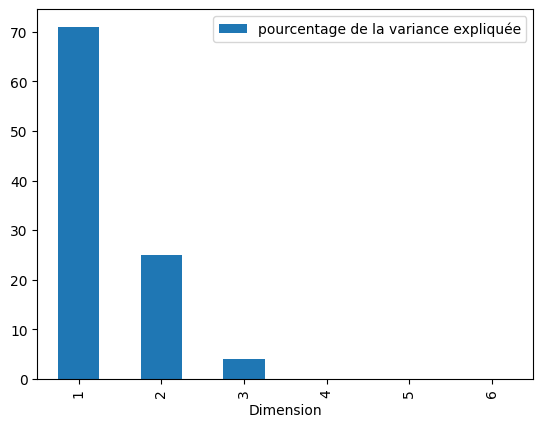

In [4]:
from sklearn.decomposition import PCA
pca = PCA() #on crée l'objet qui contient l'ACP
pca.fit(data) #on ajuste l'objet sur notre tableau de données

#La première étape est de faire un tableau de la variance expliquée
tab_variance = pd.DataFrame({
        "Dimension" : [str(i + 1) for i in range(6)], 
        "pourcentage de la variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "Variance expliquée" : pca.explained_variance_})
tab_variance.plot.bar(x = "Dimension", y = "pourcentage de la variance expliquée")
plt.show()

Ici, on se rend bien compte que les deux premières dimensions expliquent presque toutes nos données (environ 95%), ce qui va nous permettre de représenter nos données sous la forme du plan factoriel, comme suit :

      Dimension 1  Dimension 2                                  Nom
2      -92.736195   156.806870                    Rotom V (LOR 058)
13     580.130519   -37.665518          Hisuian Arcanine (LOR TG08)
16     504.608786    93.550812             Giratina VSTAR (LOR 131)
17      67.860880   -36.353462                    Gengar (LOR TG06)
20     301.049689   -36.734214                 Charizard (LOR TG03)
...           ...          ...                                  ...
3767  -176.840688   -26.238937  Origin Forme Dialga VSTAR (ASR 198)
3770  -193.683281   -35.720916                     Kamado (ASR 205)
3771  -157.743590   -34.808773                       Choy (ASR 200)
3773  -178.386171    30.643782                      Irida (ASR 204)
3774  -157.038281   -35.677880              Kleavor VSTAR (ASR 196)

[1114 rows x 3 columns]


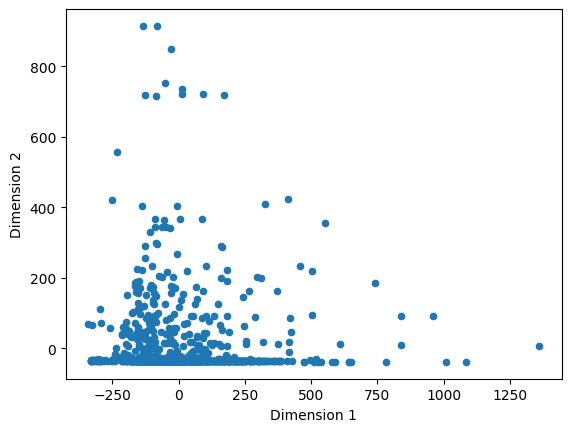

In [5]:
#On utilise la fonction transform pour calculer les coordonnées de chaque carte sur nos dimensions :
data_pca_temp = pca.transform(data)
#Puis on peut recréer un dataframe qui ne comprend que les coordonnées des deux premières dimensions et le nom de chaque carte
data_pca = pd.DataFrame({"Dimension 1" : data_pca_temp[:,0], "Dimension 2" : data_pca_temp[:,1],"Nom" : liste_noms})
print(data_pca)

data_pca.plot.scatter("Dimension 1", "Dimension 2")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

Ce graphique ne nous aide en réalité pas beaucoup à comprendre à quel point chaque variable joue un rôle dans le prix des cartes. Pour mieux relier nos dimensions trouvées aux variables de départ, on peut réaliser le cercle des corrélations comme suit :

In [8]:
nb_cartes = data.shape[0] # nombre de cartes
nb_variables = data.shape[1] # nombre de variables
valpropre = (nb_cartes-1) / nb_cartes * pca.explained_variance_ # on calcule les valeurs propres
racine_valpropre = np.sqrt(valpropre) # on calcule la racine carrée des valeurs propres
matrice_coord = np.zeros((nb_variables,nb_variables)) # on crée une matrice vide qui aura les coordonnées de chaque variable de notre jeu de données selon les deux premières dimensions

for i in range(nb_variables):
    matrice_coord[:,i] = pca.components_[i,:] * racine_valpropre[i]
# On peut maintenant créer un Dataframe qui donne les coordonnées de chacune de nos variables dans la base donnée par les deux premières dimensions
coordonnees_variables = pd.DataFrame({'Index': data.columns, 'Coord_dim_1': matrice_coord[:,0], 'Coord_dim_2': matrice_coord[:,1]})
coordonnees_variables["Coord_dim_1"]=coordonnees_variables["Coord_dim_1"]/(abs(coordonnees_variables["Coord_dim_1"]).sum())
coordonnees_variables["Coord_dim_2"]=coordonnees_variables["Coord_dim_2"]/(abs(coordonnees_variables["Coord_dim_2"]).sum())
coordonnees_variables

,Index,Coord_dim_1,Coord_dim_2
0,Min price,-0.022030,0.011250
1,Exemplaires en vente,0.878181,-0.002027
2,Tournament_last_month,0.003735,0.940374
3,Price trend num,-0.032543,0.015453
4,Price 7 days num,-0.032321,0.015723
5,Price 30 days num,-0.031190,0.015174


En regardant les valeurs, on peut déjà essayer de deviner ce qui s'est passé : la première dimension trouvée par l'ACP est quasiment égale à la variable "Exemplaires en vente", et la seconde est quasiment égale à la variable "Tournament_last_month". 
Cela voudrait dire, intuitivement, que le nombre d'exemplaires en vente et les utilisations en tournoi sont les plus gros déterminants du prix des cartes.

Traçons tout de même le cercle des corrélations.

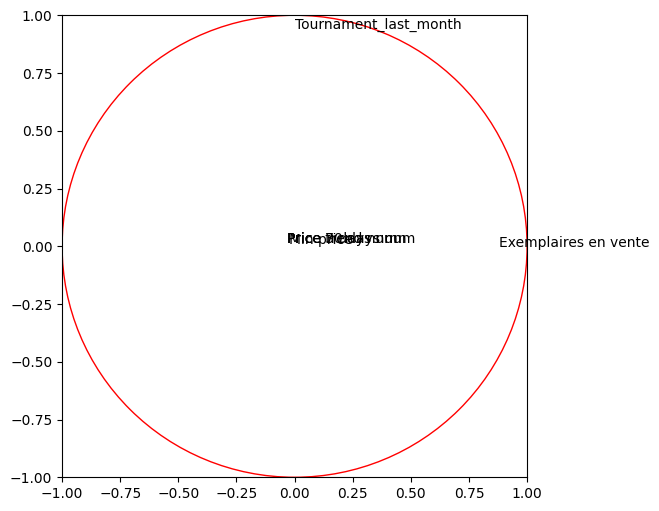

In [9]:

figure, axes = plt.subplots(figsize = (6,6)) #on crée une figure vide
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# on ajoute nos variables à la figure
for i in range(nb_variables):
    axes.text(coordonnees_variables["Coord_dim_1"][i],coordonnees_variables["Coord_dim_2"][i], coordonnees_variables["Index"][i])
# maintenant, on ajoute le cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='red',fill=False))

plt.show()

Comme on a pu le dire au début de la section, les variables de prix étant très corrélées entre elles, l'ACP nous dit simplement que les utilisations en tournoi et le nombre d'exemplaires en vente sont déterminants et décorrélés, chose à laquelle on peut s'attendre.

Au moins, l'ACP nous a montré que le nombre d'exemplaires en vente (qui se rapporte plus à la première dimension) expliquait une bien plus forte part de la variance que le nombre d'utilisations en tournoi. On a au moins appris cela.

Il convient donc de raffiner le modèle, en reprenant tout depuis le début et en limitant les variables de prix à la variable de prix "Min price".

Aussi, on va supprimer toutes les cartes de l'extention "151", car cette extension est plus susceptible que les autres de posséder des cartes aux valeurs aberrantes, pour une raison que j'explique ici : elle contient seulement les 151 premiers Pokémons, beaucoup plus appréciés par les gens et beaucoup plus populaires, faisant donc que les cartes sont plus chères.

In [31]:
original_data = pd.read_csv("original_data.csv")
original_data.to_csv("working_data.csv", index = False)

#On ne garde que les cartes 
data = pd.read_csv("working_data.csv")
data = data[(data["Rareté"] != "Online Code Card") & (data["Rareté"] != "Oversized") & (data["Rareté"] != "Fixed")]
data = data.dropna(subset=["Min price"])

data["Min price"] = (data['Min price'].str[:-5] + data['Min price'].str[-4:-2]).astype(int)/100
data = data[(data["Min price"] >= 0.5)]

data = data[(data["Expansion"] != "151")]
liste_noms=data["Name"]

data=data.loc[:,["Min price", "Exemplaires en vente","Tournament_last_month"]]
print(data)


      Min price  Exemplaires en vente  Tournament_last_month
2          0.70                   239                  193.0
13         0.50                   914                    0.0
16         2.00                   838                  131.0
17         3.10                   401                    0.0
20         4.95                   635                    0.0
...         ...                   ...                    ...
3767      10.00                   157                    9.0
3770       4.00                   139                    0.0
3771       1.50                   175                    1.0
3773       9.97                   155                   66.0
3774       5.00                   176                    0.0

[1049 rows x 3 columns]


On recommence l'ACP.


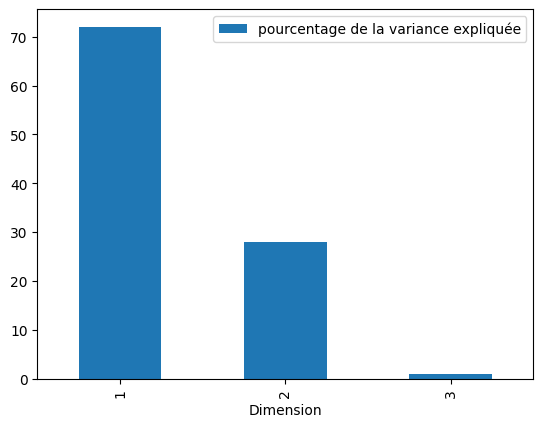

In [32]:
pca = PCA() #on crée l'objet qui contient l'ACP
pca.fit(data) #on ajuste l'objet sur notre tableau de données

#La première étape est de faire un tableau de la variance expliquée
tab_variance = pd.DataFrame({
        "Dimension" : [str(i + 1) for i in range(3)], 
        "pourcentage de la variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "Variance expliquée" : pca.explained_variance_})
tab_variance.plot.bar(x = "Dimension", y = "pourcentage de la variance expliquée")
plt.show()

On recommence le plan factoriel (car en voit qu'encore une fois la 3ème dimension explique très peu la variance expliquée). Cette fois-ci, on va essayer de retirer du nuage de points les valeurs trop grandes.

      Dimension 1  Dimension 2                                  Nom
2      -91.439615   156.842661                    Rotom V (LOR 058)
13     582.385440   -39.516153          Hisuian Arcanine (LOR TG08)
16     507.056923    91.870267             Giratina VSTAR (LOR 131)
17      69.457895   -36.926349                    Gengar (LOR TG06)
20     303.358589   -38.074661                 Charizard (LOR TG03)
...           ...          ...                                  ...
3767  -174.584172   -26.633632  Origin Forme Dialga VSTAR (ASR 198)
3770  -192.495763   -35.608332                     Kamado (ASR 205)
3771  -156.445040   -34.815336                       Choy (ASR 200)
3773  -176.284926    30.371950                      Irida (ASR 204)
3774  -155.526905   -35.782212              Kleavor VSTAR (ASR 196)

[1049 rows x 3 columns]


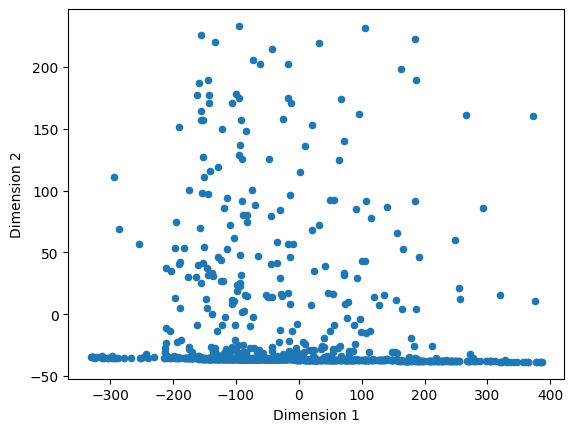

In [33]:
#On utilise la fonction transform pour calculer les coordonnées de chaque carte sur nos dimensions :
data_pca_temp = pca.transform(data)
#Puis on peut recréer un dataframe qui ne comprend que les coordonnées des deux premières dimensions et le nom de chaque carte
data_pca = pd.DataFrame({"Dimension 1" : data_pca_temp[:,0], "Dimension 2" : data_pca_temp[:,1],"Nom" : liste_noms})
print(data_pca)
data_pca = data_pca[(data_pca["Dimension 1"] <= 400)]
data_pca = data_pca[(data_pca["Dimension 2"] <= 250)]

data_pca.plot.scatter("Dimension 1", "Dimension 2")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

Et maintenant, on réessaye d'exprimer nos variables en fonction des dimensions.

In [35]:
nb_cartes = data.shape[0] # nombre de cartes
nb_variables = data.shape[1] # nombre de variables
valpropre = (nb_cartes-1) / nb_cartes * pca.explained_variance_ # on calcule les valeurs propres
racine_valpropre = np.sqrt(valpropre) # on calcule la racine carrée des valeurs propres
matrice_coord = np.zeros((nb_variables,nb_variables)) # on crée une matrice vide qui aura les coordonnées de chaque variable de notre jeu de données selon les deux premières dimensions

for i in range(nb_variables):
    matrice_coord[:,i] = pca.components_[i,:] * racine_valpropre[i]
# On peut maintenant créer un Dataframe qui donne les coordonnées de chacune de nos variables dans la base donnée par les deux premières dimensions
coordonnees_variables = pd.DataFrame({'Index': data.columns, 'Coord_dim_1': matrice_coord[:,0], 'Coord_dim_2': matrice_coord[:,1], 'Coord_dim_3': matrice_coord[:,2]})
coordonnees_variables["Coord_dim_1"]=coordonnees_variables["Coord_dim_1"]/(abs(coordonnees_variables["Coord_dim_1"]).sum())
coordonnees_variables["Coord_dim_2"]=coordonnees_variables["Coord_dim_2"]/(abs(coordonnees_variables["Coord_dim_2"]).sum())
coordonnees_variables["Coord_dim_3"]=coordonnees_variables["Coord_dim_3"]/(abs(coordonnees_variables["Coord_dim_3"]).sum())
coordonnees_variables

,Index,Coord_dim_1,Coord_dim_2,Coord_dim_3
0,Min price,-0.021254,0.010701,0.968385
1,Exemplaires en vente,0.973653,-0.004916,0.021194
2,Tournament_last_month,0.005093,0.984383,-0.010422


La première chose à noter est que, comme précédemment, on est quasiment dans le cas où chaque dimension de notre ACP correspond à chaque variable. Cependant, lorsqu'on regarde les chiffres, quelque chose de potentiellement étonnant apparaît : le prix minimum semble très décorrélé au nombre d'exemplaires en vente et au nombre d'utilisations en tournoi.

On peut en fait tenter d'expliquer cela de la manière suivante : le prix minimum (qui est bien différent du prix courant) est le prix que l'on pourrait considérer pour une carte pour ce qu'elle vaut en tant que telle, juste comme ça, en jugeant la beauté du dessin et la diffculté d'obtention lorsque l'on veut collectionner.
En soi, les utilisations en tournoi ne changent rien à la valeur intrinsèque d'une carte. Pour ce qui est du nombre d'exemplaires en vente, on peut se dire que tant que ce nombre n'est pas extrêmement bas (moins de 10 exemplaires par exemple, ce qui créerait des effets de rareté extrême attirant les collectionneurs), si une carte n'a pas une grande valeur, alors qu'il en circule sur le marché une centaine ou un millier ne changera pas grand chose à sa valeur.


On peut enchaîner avec le cercle des corrélations, même si on se doute déjà de la forme qu'il va prendre et même si on sait qu'il ne nous apprendra rien de plus.

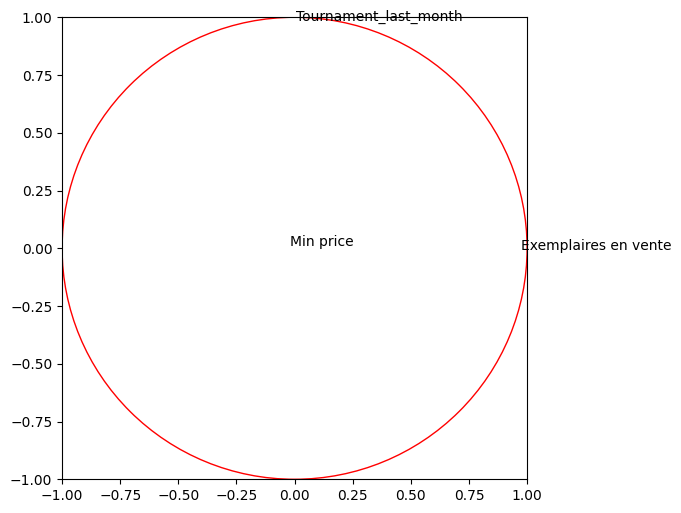

In [36]:
figure, axes = plt.subplots(figsize = (6,6)) #on crée une figure vide
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# on ajoute nos variables à la figure
for i in range(nb_variables):
    axes.text(coordonnees_variables["Coord_dim_1"][i],coordonnees_variables["Coord_dim_2"][i], coordonnees_variables["Index"][i])
# maintenant, on ajoute le cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='red',fill=False))

plt.show()

Pour conclure sur cette section concernant l'Analyse en composantes principales de notre jeu de données, il est vrai que cette ACP n'a pas été la plus révélatrice qui soit. On a quand même pu noter quelques informations : qu'on retire certaines variables de prix ou non dans l'analyse ne change rien au fait que ce qui semble expliquer la plus grosse part de variance dans notre jeu de données sont les deux variables d'utilisations en tournoi et du nombre d'exemplaires en vente.
De plus, le prix minimum n'est presque pas corrélé à ces deux variables.

On peut noter que tout ce que l'on a fait ici rencontre évidemment des limitations :
- On a dû retirer toutes les variables non numériques du jeu de données, comme l'extension, la rareté, la date de sortie, qui ont très certainement un effet sur le prix, donc on a une grosse perte d'information
- Notre échantillon n'est pas si grand que ça : en retirant toutes les cartes pour lequelles des données manquaient, on se retrouvait avec un tableau d'environ 1000 cartes
